In [13]:
%matplotlib inline

import numpy as np
import scipy.special as spc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.5)

# t = np.linspace(0, 7.0, 201)
# ss, cc = fresnel(t / np.sqrt(np.pi / 2))
# # scaled_ss = np.sqrt(np.pi / 2) * ss
# # scaled_cc = np.sqrt(np.pi / 2) * cc
# # plt.plot(t, scaled_cc, 'g--', t, scaled_ss, 'r-', linewidth=2)

# tot = 0.5 * (0.5 + ss + 0.5 + cc)**2

# plt.plot(t, tot, 'g--', t, ss, 'r-', linewidth=2)
# plt.grid(True)
# plt.show()

### Definisikan sebuah fungsi pembuat data

Data yang akan dihasilkan berupa data okultasi yang didekati melalui persamaan Fresnel.

In [46]:
from astropy import units as u

l = 5500 * 10**(-13) # panjang gelombang yang dipakai; monokromatik
# l = l.to(u.km)

D = 384000 # jarak Bumi - Bulan saat event

def make_data(x, l, D, dy=0.05, N=10000, rseed=100):
    w = x * np.sqrt(2 / (l * D))
    rand = np.random.RandomState(rseed)
    cc, ss = spc.fresnel(w / np.sqrt(np.pi/2))
    
    y = 0.5 * (0.5 + cc + 0.5 + ss)**2 # Fresnel function to simulate real data
    y += dy * rand.randn(N) # add some noise
    
    return x, l, D, y

x = np.linspace(-10,30,10000)
x, l, D, y = make_data(x, l, D) # remember, the x values are dimensionless, and a function of w

len(x), len(y)

(10000, 10000)

### Plot generated data

Text(0,0.5,'$I$')

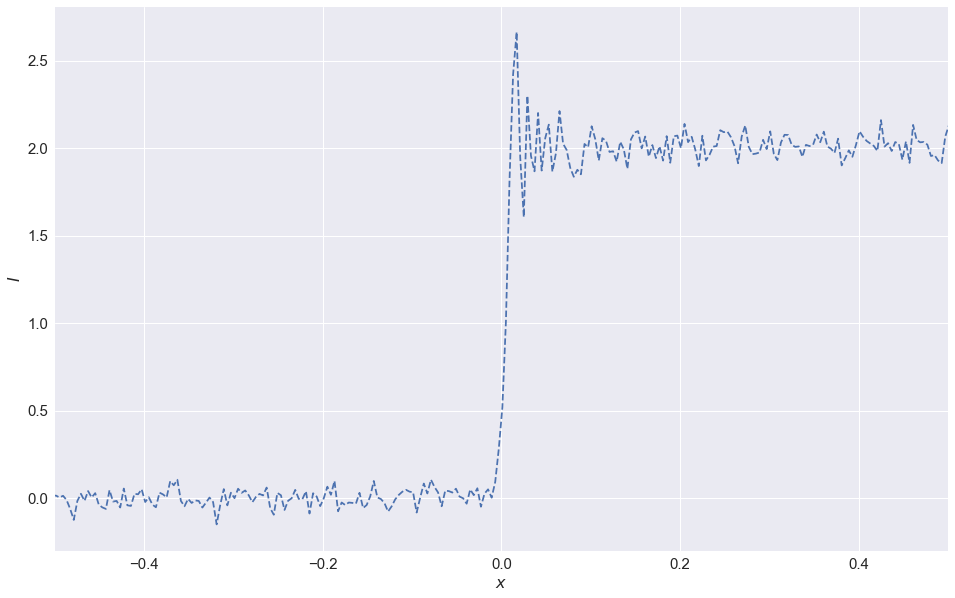

In [45]:
plt.figure(figsize=(16,10)) 

# plt.scatter(x,y, marker='.') 
plt.plot(x, y, '--')
plt.xlim(-0.5,0.5)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$I$', fontsize=16)

### Definisikan model

In [ ]:
from pymc3 import Model, Normal, HalfNormal

cc, ss = spc.fresnel(w / np.sqrt(np.pi/2))

# context manager syntax
with Model() as basic_model:
    # prior for unknown
    w = Normal('w', mu = 0., sd = 10.)
    dy = HalfNormal('error', sd = 1.)
    
    # expected values of outcome
    
    mu = 0.5 * (0.5 + cc + 0.5 + ss)**2
#     mu = spc.fresnel(w / np.sqrt(np.pi/2) )
    
    # likelihood of observations
    y_obs = Normal('y_obs', mu = mu, sd = dy, observed = y)

### Metode MAP untuk nilai awal

In [ ]:
from pymc3 import find_MAP # menggunakan algoritma optimisasi BFGS (Broyden-Fletcher-Goldfarb-Shanno)

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

### Sampling dengan NUTS

In [ ]:
from pymc3 import NUTS, sample

with basic_model:
    start = find_MAP(method="L-BFGS-B") # MAP method untuk nilai awal
    
    # instantiate sampler
    step = NUTS(scaling=start)
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

In [ ]:
from pymc3 import summary
summary(trace, ['w','error'])

In [ ]:
from pymc3 import traceplot
traceplot(trace, figsize = (16,10))

from pymc3 import plot_posterior
plot_posterior(trace, varnames=None, figsize = (16,10))

In [ ]:
from pymc3 import energyplot
energyplot(trace, figsize = (16,10))

In [ ]:
size=(16,10)

plt.figure(figsize=size)

ax = plt.subplot()

xx = np.linspace(-100,100,num=8000)

t = np.mean(trace['w'])
cc1, ss1 = spc.fresnel(t / np.sqrt(np.pi/2))


yy = 0.5 * (0.5 + cc1 + 0.5 + ss1)**2
# yy = np.mean(trace['intercept']) + np.mean(trace['slope'])*xx
# total_yy = yy.sum(axis=1)
# plt.plot(x, y, 'o')
# yy1 = yy - np.mean(trace['error'])
# yy2 = yy + np.mean(trace['error'])

# plt.plot(x,y,'ok')
plt.scatter(x,y, marker='.', alpha=0.5)
# plt.plot(xx, spc.fresnel(t / np.sqrt(np.pi/2)))
# plt.plot(xx, yy, '-g', alpha=.3)

# ax.plot(xx, yy, '-g', alpha=.5)
# ax.plot(xx, yy1, '--r', alpha=0.5)
# ax.plot(xx, yy2, '--r', alpha=0.5)
# plt.fill_between(xx, yy1, yy2, facecolor="gray", alpha=0.15)
# len(cc1)

In [ ]:
trace['w'][100]